## Getting Audio Features for All Tracks in a Playlist

This notebook goes through the basic process of using [Spotipy](https://spotipy.readthedocs.io/en/2.11.1/) to access the Spotify API and (as the title says) search for a playlist, get all its tracks, and finally get the [Spotify Audio Features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) for these tracks -- along with a short analysis.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from IPython.display import YouTubeVideo, IFrame
from scipy.spatial.distance import cosine

Let's use the [Client Credentials Flow](https://spotipy.readthedocs.io/en/2.11.1/#client-credentials-flow) to access the API. I followed the details in this [post](https://medium.com/@maxtingle/getting-started-with-spotifys-api-spotipy-197c3dc6353b) to set up my credentials.

In [2]:
cid = # your client id
secret = # your client secret
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Now let's do a playlist search of playlists of songs from Apple commercials, and pick out the first one returned to analyze:

In [3]:
playlist_search = sp.search(q='apple commercial songs', type='playlist')
apple_comm_songs = playlist_search['playlists']['items'][0]

In [4]:
print(apple_comm_songs['uri'])
print(apple_comm_songs['name'])

spotify:playlist:3mbFWxQz8zYFV0YzdBHQ9L
Apple Commercial Songs (Updated:  April, 2020)


Let's now test out getting info about the first track from this playlist and its audio features:

In [5]:
sp.playlist_tracks(apple_comm_songs['uri'])['items'][0]['track']['artists'][0]['name'] # Artist

'Anna of the North'

In [6]:
sp.playlist_tracks(apple_comm_songs['uri'])['items'][0]['track']['name'] # Track Title

'Dream Girl'

In [7]:
sp.playlist_tracks(apple_comm_songs['uri'])['items'][0]['track']['uri'] # URI

'spotify:track:0ZrUS7VVKYmt5VUasiPdXI'

In [8]:
sp.audio_features('spotify:track:0ZrUS7VVKYmt5VUasiPdXI') # audio features

[{'acousticness': 0.765,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0ZrUS7VVKYmt5VUasiPdXI',
  'danceability': 0.674,
  'duration_ms': 151680,
  'energy': 0.494,
  'id': '0ZrUS7VVKYmt5VUasiPdXI',
  'instrumentalness': 3.55e-05,
  'key': 0,
  'liveness': 0.0879,
  'loudness': -5.694,
  'mode': 0,
  'speechiness': 0.0455,
  'tempo': 79.035,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/0ZrUS7VVKYmt5VUasiPdXI',
  'type': 'audio_features',
  'uri': 'spotify:track:0ZrUS7VVKYmt5VUasiPdXI',
  'valence': 0.525}]

Now we'll go ahead and collect all the individual track information into a dataframe:

In [9]:
def playlist_audio_features_df(playlist_tracks):
    track_dict = {}
    
    for i, track in enumerate(playlist_tracks.get('items', [])):
        track_dict[track['track']['uri']] = [track['track']['name'], track['track']['artists'][0]['name']]
        track_dict[track['track']['uri']].extend([v for v in sp.audio_features(track['track']['uri'])[0].values()])
        if i == 0:
            audio_feat = [k for k in sp.audio_features(track['track']['uri'])[0].keys()]
        
    audio_feat_df = pd.DataFrame.from_dict(track_dict, orient='index')
    audio_feat_df.columns = ['title', 'artist'] + audio_feat
    
    return audio_feat_df

In [10]:
tracks = sp.playlist_tracks(apple_comm_songs['uri'])
audio_features_df = playlist_audio_features_df(tracks)
while tracks['next']:
    tracks = sp.next(tracks)
    tmp_df = playlist_audio_features_df(tracks)
    audio_features_df = pd.concat([audio_features_df, tmp_df])
audio_features_df = audio_features_df.reset_index().drop(columns='index')
audio_features_df

,title,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Dream Girl,Anna of the North,0.674,0.494,0,-5.694,0,0.0455,0.765000,0.000036,0.0879,0.5250,79.035,audio_features,0ZrUS7VVKYmt5VUasiPdXI,spotify:track:0ZrUS7VVKYmt5VUasiPdXI,https://api.spotify.com/v1/tracks/0ZrUS7VVKYmt...,https://api.spotify.com/v1/audio-analysis/0ZrU...,151680,4
1,Asleep at the Parade,The Young Ebenezers,0.792,0.216,10,-18.895,1,0.0541,0.993000,0.911000,0.1140,0.2640,115.028,audio_features,5Sjtb4RBxvLmvHwPE0PTZZ,spotify:track:5Sjtb4RBxvLmvHwPE0PTZZ,https://api.spotify.com/v1/tracks/5Sjtb4RBxvLm...,https://api.spotify.com/v1/audio-analysis/5Sjt...,94582,3
2,The Difference,Flume,0.560,0.865,1,-1.148,1,0.0909,0.255000,0.000153,0.0830,0.4240,159.960,audio_features,4nlvKIIetOWGIMyhjQXgOZ,spotify:track:4nlvKIIetOWGIMyhjQXgOZ,https://api.spotify.com/v1/tracks/4nlvKIIetOWG...,https://api.spotify.com/v1/audio-analysis/4nlv...,139663,4
3,Stupid Love,Lady Gaga,0.676,0.815,8,-4.294,1,0.0625,0.001460,0.000410,0.2750,0.7960,117.973,audio_features,2kJu14V7hbZw3I4K8L8SXb,spotify:track:2kJu14V7hbZw3I4K8L8SXb,https://api.spotify.com/v1/tracks/2kJu14V7hbZw...,https://api.spotify.com/v1/audio-analysis/2kJu...,193531,4
4,***Flawless (feat. Chimamanda Ngozi Adichie),Beyoncé,0.476,0.688,1,-7.799,1,0.2450,0.095300,0.000645,0.4380,0.3520,140.553,audio_features,7tefUew2RUuSAqHyegMoY1,spotify:track:7tefUew2RUuSAqHyegMoY1,https://api.spotify.com/v1/tracks/7tefUew2RUuS...,https://api.spotify.com/v1/audio-analysis/7tef...,250960,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,Balla Balla,Brazilian Girls,0.671,0.854,10,-7.118,0,0.0427,0.045600,0.317000,0.0886,0.3310,108.980,audio_features,3Zz6s2igHj1MaVTBWNz0BY,spotify:track:3Zz6s2igHj1MaVTBWNz0BY,https://api.spotify.com/v1/tracks/3Zz6s2igHj1M...,https://api.spotify.com/v1/audio-analysis/3Zz6...,284047,4
480,Young,Jaded,0.831,0.839,7,-5.234,1,0.0623,0.036100,0.001190,0.0849,0.5580,104.015,audio_features,3GpxUJeWPevtO37bbVkf3B,spotify:track:3GpxUJeWPevtO37bbVkf3B,https://api.spotify.com/v1/tracks/3GpxUJeWPevt...,https://api.spotify.com/v1/audio-analysis/3Gpx...,140759,4
481,No Brainer,DJ Khaled,0.552,0.760,0,-4.706,1,0.3420,0.073300,0.000000,0.0865,0.6390,135.702,audio_features,5WvAo7DNuPRmk4APhdPzi8,spotify:track:5WvAo7DNuPRmk4APhdPzi8,https://api.spotify.com/v1/tracks/5WvAo7DNuPRm...,https://api.spotify.com/v1/audio-analysis/5WvA...,260000,5
482,"1,2,1,2",George The Poet,0.841,0.712,6,-8.782,0,0.2110,0.076100,0.000996,0.1870,0.6810,119.988,audio_features,70OQhhSB6LFF10HsQwSQNn,spotify:track:70OQhhSB6LFF10HsQwSQNn,https://api.spotify.com/v1/tracks/70OQhhSB6LFF...,https://api.spotify.com/v1/audio-analysis/70OQ...,224221,4


Let's now focus on the nine primary audio features, as detailed [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). Since we can clearly see that the `tempo` and `loudness` are on different scales from the remaining features, let's also standardize everything.

In [11]:
main_audio_features = ['acousticness',
                       'danceability',
                       'energy',
                       'instrumentalness',
                       'liveness',
                       'loudness',
                       'speechiness',
                       'valence',
                       'tempo']
audio_features_scaled = (audio_features_df[main_audio_features] - audio_features_df[main_audio_features].mean()) / audio_features_df[main_audio_features].std()

Taking a look at the distributions of the standardized features, it's hard to see serious deviations from the distribution across all Spotify tracks -- i.e., the songs in Apple commercials are fairly representative of music on Spotify in general and perhaps there's no specific "type" of song that ends up in Apple commercials:

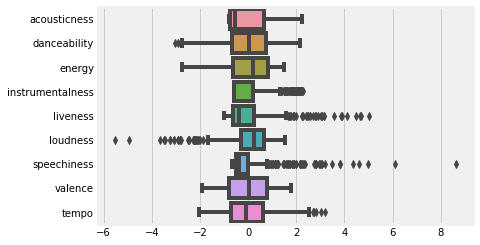

In [12]:
sns.boxplot(data=audio_features_scaled, orient='h')

Let's still go forward and try to understand the features of the Apple-est track. As the audio features mostly have skewed distributions, we'll use the median as our measure of central tendency for all features:

In [13]:
median_track = audio_features_scaled.median()
median_track

acousticness       -0.548998
danceability        0.056254
energy              0.220287
instrumentalness   -0.588169
liveness           -0.382293
loudness            0.251512
speechiness        -0.366855
valence             0.028113
tempo              -0.089055
dtype: float64

What does this say? Seems as if the Apple-est track is kind of right down the middle as far as `tempo`, `valence` and `danceability` go -- which I suppose makes sense if Apple sometimes develops commercials that are better paired with slower or sadder music while others are more "celbratory" in nature. The Apple-est track does seem to be definitively enough not very acoustic, instrumental or speechy, but also kind of more than a middling amount of `energy` and `loudness` regardless of whatever emotion or tone their commercials are attempting to capture.

Let's take the distance of each actual track from this theoretical Apple-est track to see which are the most and least representative of the tracks used in Apple commercials: 

In [14]:
dist_from_median_track = [np.sqrt(np.sum((median_track - row[1])**2)) for row in audio_features_scaled.iterrows()]

Here are the 10 Apple-est tracks of all of them:

In [15]:
top10 = audio_features_df.iloc[np.argsort(dist_from_median_track)[:10].tolist()][['title', 'artist']]
top10

,title,artist
233,Inside Your Head,Eberg
158,Ojai,Young & Sick
364,Sun's Comin' up,Animal Fiction
126,Misbehaving,Labrinth
291,Somnambulist (Simply Being Loved),BT
134,La La La,the bird and the bee
318,We Turn It Up,Oh Land
66,"Heavy, California",Jungle
342,Good Life,OneRepublic
13,Sympathy,Vampire Weekend


In [16]:
search_str = top10.iloc[0]['title'] + ' ' + top10.iloc[0]['artist']
search_str

'Inside Your Head Eberg'

In [17]:
track_id = sp.search(search_str)['tracks']['items'][0]['id']
IFrame(src = 'https://open.spotify.com/embed/track/' + track_id, width='300', height='380')

I've never heard this song before now and don't recall an Apple commercial featuring it. It actually kind of fits, in my opinion though.

Now for the unApple-est tracks of all the tracks:

In [18]:
bottom10 = audio_features_df.iloc[np.argsort(dist_from_median_track)[::-1][:10].tolist()][['title', 'artist']]
bottom10

,title,artist
55,Ann Arbor Part 1,Shigeto
280,Brandenburg Concerto No. 5 in D Major,Munich Chamber Orchestra
53,Stay Awake,Julie Andrews
295,It's Like That - feat. Casual + I Am Complete ...,Handsome Boy Modeling School
73,Blue (From the 'Photos Every Day' TV Advert),L'Orchestra Cinematique
439,Last Rites / Loved to Deth - Remastered,Megadeth
459,Like Home,Trent Reznor
176,I Happen to Like New York (From the New Yorker...,Bobby Short
27,Eighteenth,Corre
337,Waltz Of The Flowers,San Francisco Ballet Orchestra


Well some of this makes sense, what with all the instrumentals and artists like Megadeth and Trent Reznor (and Julie Andrews?)

Digging a little deeper into the features of the Apple-est and unApple-est just to see how well everything lines up -- and 'Inside Your Head' certainly lines up quite well with the theoretical Apple-est track in terms of `acousticness`, `energy`, `instrumentalness`, `liveness`, `speechiness` and `tempo`.

In [19]:
audio_features_scaled.iloc[np.argsort(dist_from_median_track)[0]]

acousticness       -0.658469
danceability        0.516724
energy              0.224541
instrumentalness   -0.489717
liveness           -0.595285
loudness           -0.225638
speechiness        -0.378476
valence            -0.498222
tempo               0.054214
Name: 233, dtype: float64

As for the unApple-est track "Ann Arbor Part 1," it's not hard to see how it ended up that way with how much of an outlier it appears to be for `speechiness` as well as being off the norm in terms of `energy`, `liveness`, and `energy`.

In [20]:
audio_features_scaled.iloc[np.argsort(dist_from_median_track)[-1]]

acousticness       -0.759519
danceability       -0.568887
energy              1.104950
instrumentalness   -0.591448
liveness            1.454603
loudness            0.045156
speechiness         8.643689
valence             0.336258
tempo              -1.108983
Name: 55, dtype: float64

I am not sure I'm buying how speechy and live this is, nor how lacking in instrumentals either, though:

In [21]:
search_str2 = bottom10.iloc[0]['title'] + ' ' + bottom10.iloc[0]['artist']
track_id2 = sp.search(search_str2)['tracks']['items'][0]['id']
IFrame(src = 'https://open.spotify.com/embed/track/' + track_id2, width='300', height='380')